### Reference
- https://medium.com/@neotheicebird/webcam-based-image-processing-in-ipython-notebooks-47c75a022514

In [1]:
%matplotlib inline

import numpy as np
import cv2
import matplotlib.pyplot as plt
import signal
from IPython import display

from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder
from skimage.transform import resize
from keras.models import load_model

Using TensorFlow backend.


In [2]:
cascade_path = '../model/cv2/haarcascade_frontalface_alt2.xml'

In [3]:
model_path = '../model/facenet_keras.h5'
model = load_model(model_path)

C:\Users\karth\Anaconda3\envs\DL\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [4]:
def prewhiten(x):
    if x.ndim == 4:
        axis = (1, 2, 3)
        size = x[0].size
    elif x.ndim == 3:
        axis = (0, 1, 2)
        size = x.size
    else:
        raise ValueError('Dimension should be 3 or 4')

    mean = np.mean(x, axis=axis, keepdims=True)
    std = np.std(x, axis=axis, keepdims=True)
    std_adj = np.maximum(std, 1.0/np.sqrt(size))
    y = (x - mean) / std_adj
    return y

def l2_normalize(x, axis=-1, epsilon=1e-10):
    output = x / np.sqrt(np.maximum(np.sum(np.square(x), axis=axis, keepdims=True), epsilon))
    return output

In [5]:
def calc_embs(imgs, margin, batch_size):
    aligned_images = prewhiten(imgs)
    pd = []
    for start in range(0, len(aligned_images), batch_size):
        pd.append(model.predict_on_batch(aligned_images[start:start+batch_size]))
    embs = l2_normalize(np.concatenate(pd))

    return embs

In [6]:
class FaceDemo(object):
    def __init__(self, cascade_path):
        self.vc = None
        self.cascade = cv2.CascadeClassifier(cascade_path)
        self.margin = 10
        self.batch_size = 1
        self.n_img_per_person = 10
        self.is_interrupted = False
        self.data = {}
        self.le = None
        self.clf = None
        
    def _signal_handler(self, signal, frame):
        self.is_interrupted = True
        
    def capture_images(self, name='Unknown'):
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        imgs = []
        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        while is_capturing:
            is_capturing, frame = vc.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            if len(faces) != 0:
                face = faces[0]
                (x, y, w, h) = face
                left = x - self.margin // 2
                right = x + w + self.margin // 2
                bottom = y - self.margin // 2
                top = y + h + self.margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                imgs.append(img)
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)

            plt.imshow(frame)
            plt.title('{}/{}'.format(len(imgs), self.n_img_per_person))
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            if len(imgs) == self.n_img_per_person:
                vc.release()
                self.data[name] = np.array(imgs)
                break
            try:
                plt.pause(0.1)
            except Exception:
                pass
            if self.is_interrupted:
                vc.release()
                break
                
    def train(self):
        labels = []
        embs = []
        names = self.data.keys()
        for name, imgs in self.data.items():
            embs_ = calc_embs(imgs, self.margin, self.batch_size)    
            labels.extend([name] * len(embs_))
            embs.append(embs_)

        embs = np.concatenate(embs)
        le = LabelEncoder().fit(labels)
        y = le.transform(labels)
        clf = SVC(kernel='linear', probability=True).fit(embs, y)
        
        self.le = le
        self.clf = clf
        
    def infer(self):
        vc = cv2.VideoCapture(0)
        self.vc = vc
        if vc.isOpened():
            is_capturing, _ = vc.read()
        else:
            is_capturing = False

        signal.signal(signal.SIGINT, self._signal_handler)
        self.is_interrupted = False
        while is_capturing:
            is_capturing, frame = vc.read()
            frame = cv2.cvtColor(frame, cv2.COLOR_BGR2RGB)
            faces = self.cascade.detectMultiScale(frame,
                                         scaleFactor=1.1,
                                         minNeighbors=3,
                                         minSize=(100, 100))
            pred = None
            if len(faces) != 0:
                face = faces[0]
                (x, y, w, h) = face
                left = x - self.margin // 2
                right = x + w + self.margin // 2
                bottom = y - self.margin // 2
                top = y + h + self.margin // 2
                img = resize(frame[bottom:top, left:right, :],
                             (160, 160), mode='reflect')
                embs = calc_embs(img[np.newaxis], self.margin, 1)
                pred = self.le.inverse_transform(self.clf.predict(embs))
                cv2.rectangle(frame,
                              (left-1, bottom-1),
                              (right+1, top+1),
                              (255, 0, 0), thickness=2)
            plt.imshow(frame)
            plt.title(pred)
            plt.xticks([])
            plt.yticks([])
            display.clear_output(wait=True)
            try:
                plt.pause(0.1)
            except Exception:
                pass
            if self.is_interrupted:
                vc.release()
                break

In [7]:
f = FaceDemo(cascade_path)

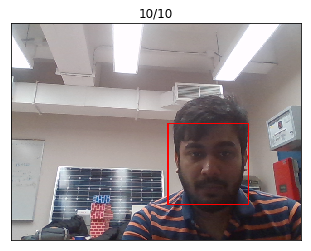

In [8]:
# Train with two or more people
f.capture_images('nyoki-mtl')

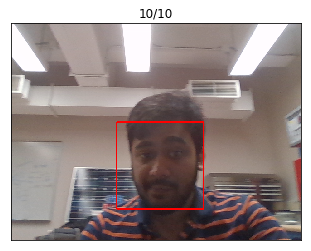

In [10]:
f.capture_images('abc')

In [11]:
f.train()

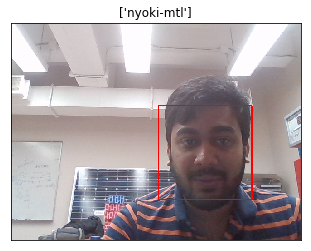

In [12]:
f.infer()